/home/fall/anaconda3/envs/ldms_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Using 4 GPUs for parallel processing


100%|██████████| 25/25 [00:04<00:00,  5.27it/s]


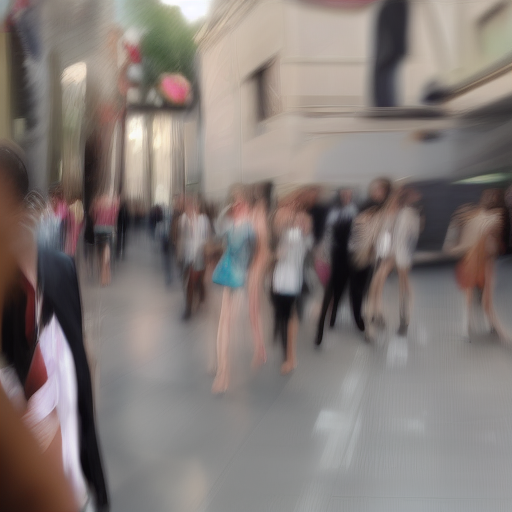

In [1]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
import os

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "/home/NAS_mount/seunghan/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

if torch.cuda.device_count() > 1 and DEVICE == "cuda":
    print(f"Using {torch.cuda.device_count()} GPUs for parallel processing")
    models = torch.nn.DataParallel(models, device_ids=list(range(torch.cuda.device_count())))


## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "deblurred image"
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14 prompt에 집중하는 정도

## IMAGE TO IMAGE

input_image = None
# Comment to disable image to image
image_path = "../images/blur_image.png"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.5

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models.module if isinstance(models, torch.nn.DataParallel) else models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

input_image = Image.open(image_path).convert("RGB").resize((512, 512))
# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

Using device: cuda
Using 4 GPUs for parallel processing


100%|██████████| 25/25 [00:04<00:00,  5.28it/s]


Input image saved to ./generated_outputs/input_image_resized.png
Deblurred image saved to ./generated_outputs/deblurred_image.png


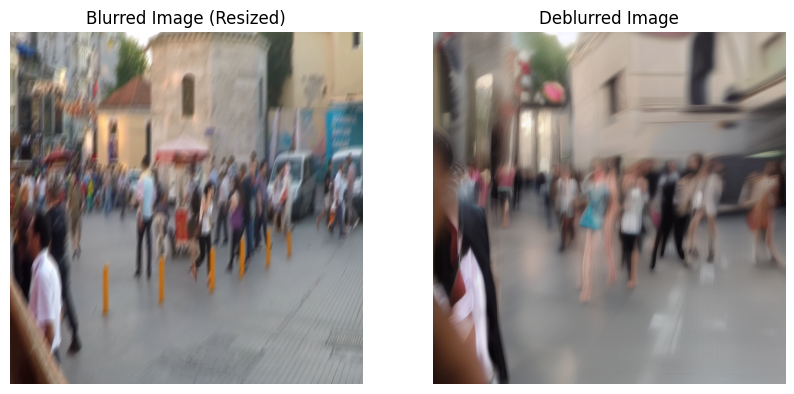

: 

In [ ]:
import model_loader
import pipeline
from PIL import Image
from transformers import CLIPTokenizer
import torch
import os

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = True

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

# Load tokenizer and models
tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "/home/NAS_mount/seunghan/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

if torch.cuda.device_count() > 1 and DEVICE == "cuda":
    print(f"Using {torch.cuda.device_count()} GPUs for parallel processing")
    models = torch.nn.DataParallel(models, device_ids=list(range(torch.cuda.device_count())))

# Prompt and sampling settings
prompt = "deblurred image"
uncond_prompt = ""  # Negative prompt
do_cfg = True
cfg_scale = 8
sampler = "ddpm"
num_inference_steps = 50
seed = 42
strength = 0.5

# Load and resize input image
image_path = "../images/blur_image.png"
input_image = Image.open(image_path).convert("RGB").resize((512, 512))

# Generate deblurred image
output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models.module if isinstance(models, torch.nn.DataParallel) else models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Save and display images
output_dir = "./generated_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save input image
input_image.save(os.path.join(output_dir, "input_image_resized.png"))
print(f"Input image saved to {output_dir}/input_image_resized.png")

# Save generated image
deblurred_image = Image.fromarray(output_image)
deblurred_image.save(os.path.join(output_dir, "deblurred_image.png"))
print(f"Deblurred image saved to {output_dir}/deblurred_image.png")

# Display the images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Blurred Image (Resized)")
plt.imshow(input_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Deblurred Image")
plt.imshow(deblurred_image)
plt.axis("off")

plt.show()
